In [58]:
import os
import cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
from tqdm import tqdm
import plotly.graph_objects as go

#### Preparing the dataset

In [59]:
poses = pd.read_csv('./poses/00.txt', header=None, sep=' ')
calib = pd.read_csv('./00_gray/calib.txt', header=None, sep=' ', index_col=0)

In [60]:
total_images = len(os.listdir('./00_gray/image_0/'))
num_images = 201

In [61]:

dir_images_0 = './00_gray/image_0/'
dir_images_1 = './00_gray/image_1/'

images_0_files = os.listdir(dir_images_0)[:num_images]
images_1_files = os.listdir(dir_images_1)[:num_images]

In [62]:
images_left = []
images_right = []

for file in images_0_files:
    img_path = os.path.join(dir_images_0, file)
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    images_left.append(img)

for file in images_1_files:
    img_path = os.path.join(dir_images_1, file)
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    images_right.append(img)

images_left = np.array(images_left)
images_right = np.array(images_right)

#### Pipeline

In [63]:
def compute_disparity(image_left, image_right, matcher='sgbm'):
    
    sad_window = 6
    num_disparities = sad_window * 16
    block_size = 7
    matcher_name = matcher
    
    if matcher_name == 'bm':
        matcher = cv2.StereoBM_create(numDisparities=num_disparities, blockSize=block_size)
    else:
        matcher = cv2.StereoSGBM_create(
                                        numDisparities=num_disparities, 
                                        blockSize=block_size,
                                        minDisparity=0,
                                        P1= 8 * 1 * block_size ** 2,
                                        P2= 33 * 1 * block_size ** 2,
                                        mode=cv2.StereoSGBM_MODE_SGBM_3WAY
                                      )
        
    disp_left = matcher.compute(image_left, image_right).astype(np.float32) / 16
    return disp_left

In [64]:
def decompose_proj(P):
    k, r, t, _, _, _, _ = cv2.decomposeProjectionMatrix(P)

    t = (t / t[3])[:3] # Bayad akharesh 1 bashe ta toye meter bashe
     
    return k, r, t

In [65]:
def calc_depth_Z(disp_l, k_left, t_left, t_right):
    b = t_right[0] - t_left[0]
    
    f = k_left[0][0]
    
    disp_l[disp_l==0.0] = 0.1
    disp_l[disp_l==-1.0] = 0.1
    
    depth_map = np.ones(disp_l.shape)
    ''' 
        f is focal length
        b is the base line
        
        d is the difference between x_L and x_R, 
            meaning the difference in horizontal pixel location of
            the point projected onto the left and right image planes.

        depth_map is Z    
    '''
    depth_map = (f * b) / disp_l 
    
    return depth_map

In [66]:
def stereo_2_depth(img_left, img_right, P0, P1, matcher='bm'):
    disp = compute_disparity(
                                img_left,
                                img_right,
                                matcher=matcher,
                            )
    k_left, r_left, t_left = decompose_proj(P0)
    k_right, r_right, t_right = decompose_proj(P1)
    
    depth = calc_depth_Z(disp, k_left, t_left, t_right)
    
    return depth

In [67]:
def extract_features(image, detector='sift', mask=None):
    if detector == 'sift':
        det = cv2.SIFT_create()
    elif detector == 'orb':
        det = cv2.ORB_create()
    elif detector == 'surf':
        det = cv2.xfeatures2d.SURF_create()
        
    kp, des = det.detectAndCompute(image, mask)
    
    return kp, des

In [68]:
def match_features(des1, des2, matching='BF', detector='sift', sort=True, k=2, dist_threshold=0.4):
    if matching == 'BF':
        if detector == 'sift':
            matcher = cv2.BFMatcher_create(cv2.NORM_L2, crossCheck=False)
        elif detector == 'orb':
            matcher = cv2.BFMatcher_create(cv2.NORM_HAMMING2, crossCheck=False)
            
        matches = matcher.knnMatch(des1, des2, k=k)
    
    elif matching == 'FLANN':
        FLANN_INDEX_KDTREE = 1
        index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees=5)
        search_params = dict(checks=150)
        matcher = cv2.FlannBasedMatcher(index_params, search_params)
        matches = matcher.knnMatch(des1, des2, k=k)
    
    if sort:
        matches = sorted(matches, key = lambda x:x[0].distance)

    filtered_match = []
    for m, n in matches:
        if m.distance <= dist_threshold*n.distance:
            filtered_match.append(m)

    return filtered_match

In [69]:
def estimate_motion(matches, kp1, kp2, k, depth, max_depth=3000, confidence=0.99):
    cx = k[0, 2]
    cy = k[1, 2]
    fx = k[0, 0]
    fy = k[1, 1]
    
    rmat = np.eye(3)
    tmat = np.zeros((3, 1))
    
    image_points1 = np.float32([kp1[m.queryIdx].pt for m in matches])
    image_points2 = np.float32([kp2[m.trainIdx].pt for m in matches])
    
    ''' X Y Z '''
    object_points = np.zeros((0, 3))
    feature_points = []
    delete = []
    
    '''2d coordinates'''
    for i, (u, v) in enumerate(image_points1): 
        Z = depth[int(round(v)), int(round(u))]
        
        if Z > max_depth:
            delete.append(i)
            continue
        
        X = Z * (u - cx) / fx
        Y = Z * (v - cy) / fy
        
        object_points = np.vstack((
                                    object_points, 
                                    np.array([X, Y, Z])
                                   ))
        
        feature_points.append(np.array([X, Y, Z]))
        
        local_point = np.array([X, Y, Z, 1]).T
        
    image_points1 = np.delete(image_points1, delete, 0)
    image_points2 = np.delete(image_points2, delete, 0)
    
    _, rvec, tvec, inliers = cv2.solvePnPRansac(object_points, image_points2, k, None, confidence=confidence)
    
    '''rvec 3x1 to rmat 3x3'''
    rmat = cv2.Rodrigues(rvec)[0]
    
    '''  [R|t] '''
    return rmat, tvec, object_points, feature_points

In [70]:
def VO():
    start = datetime.datetime.now()
    print(f'Start Time = {start}')
    num_frames = num_images - 1
    
    P0 = np.array(calib.loc['P0:']).reshape(3, 4)
    P1 = np.array(calib.loc['P1:']).reshape(3, 4)
    
    T_tot = np.eye(4)
    trajectory = np.zeros((num_frames + 1, 3, 4))
    trajectory[0] = T_tot[:3, :]
    
    k_left, r_left, t_left = decompose_proj(P0)
    
    global_feature_coordinates = []

    for i in tqdm(range(num_frames), desc="Processing Frames", unit="frame"):
        image_left = images_left[i]
        image_right = images_right[i]
        
        image_plus1 = images_left[i + 1]
        
        depth = stereo_2_depth(image_left, image_right, P0, P1, 'sgbm')
        
        kp0, des0 = extract_features(image_left)
        kp1, des1 = extract_features(image_plus1)
        
        matches = match_features(des0, des1, matching='FLANN', dist_threshold=0.3)
        
        rmat, tvec, object_points, feature_points = estimate_motion(matches, kp0, kp1, k_left, depth)
        
        Tmat = np.eye(4)
        Tmat[:3, :3] = rmat
        Tmat[:3, 3] = tvec.T
        
        T_tot = T_tot.dot(np.linalg.inv(Tmat))
        
        trajectory[i + 1, :, :] = T_tot[:3, :]

        i_features = []
        for pt in feature_points:
            local_point = np.array([pt[0], pt[1], pt[2], 1]).T  
            global_point = T_tot.dot(local_point)  
            i_features.append(global_point[:3])  
        global_feature_coordinates.append(i_features)  

    end = datetime.datetime.now()
    print(f'Total Time = {end - start}')
    
    
    return trajectory, object_points, global_feature_coordinates


In [71]:
def calculate_error(gt, est, num_frames):
    squared_diffs = (gt.iloc[:num_frames, 3] - est[:, 0, 3])**2 + (gt.iloc[:num_frames, 7] - est[:, 1, 3])**2 + (gt.iloc[:num_frames, 11] - est[:, 2, 3])**2
    
    rmse = np.sqrt(np.mean(squared_diffs))
    
    return rmse

In [72]:
trajectory, object_points, feature_coardinates = VO()
rmse = calculate_error(poses, trajectory, num_images)

print('==========================')
print(f'RMSE: {rmse}')
print('==========================')

Start Time = 2024-11-26 17:44:08.600795


Processing Frames: 100%|██████████| 200/200 [00:54<00:00,  3.69frame/s]

Total Time = 0:00:54.188791
RMSE: 2.3207722240479827


In [16]:
# import pickle

# with open("vo_output.pkl", "wb") as f:
#     pickle.dump((trajectory, object_points, feature_coardinates), f)

# print("VO output saved to 'vo_output.pkl'")

In [17]:
# import pickle

# with open("vo_output.pkl", "rb") as f:
#     trajectory, object_points, feature_coardinates = pickle.load(f)

# print("VO output loaded successfully!")


In [18]:
def visualize_animated_path(points, trajectory, title="3D Animated Trajectory"):
    points = np.array(points, dtype=object)

    pose_xs = poses.iloc[:num_images, 3].values  
    pose_ys = poses.iloc[:num_images, 7].values  
    pose_zs = poses.iloc[:num_images, 11].values  

    traj_xs = trajectory[:, 0, 3]
    traj_ys = trajectory[:, 1, 3]
    traj_zs = trajectory[:, 2, 3]

    frames = []
    num_frames = len(traj_xs)

    for i in range(num_frames - 1):
        frame_points = np.array(points[i])  
        feat_X = frame_points[:, 0]
        feat_Y = frame_points[:, 1]
        feat_Z = frame_points[:, 2]

        frames.append(
            go.Frame(
                data=[
                    go.Scatter3d(
                        x=traj_xs[:i+1],
                        y=traj_ys[:i+1],
                        z=traj_zs[:i+1],
                        mode='lines',
                        line=dict(color='cyan', width=5),
                        name='Trajectory',
                    ),
                    go.Scatter3d(
                        x=[traj_xs[i]],
                        y=[traj_ys[i]],
                        z=[traj_zs[i]],
                        mode='markers',
                        marker=dict(size=5, color='cyan'),
                        name='Current Position',
                    ),
                    go.Scatter3d(
                        x=pose_xs[:i+1],
                        y=pose_ys[:i+1],
                        z=pose_zs[:i+1],
                        mode='lines',
                        line=dict(color='pink', width=5),
                        name='Ground Truth',
                    ),
                    go.Scatter3d(
                        x=[pose_xs[i]],
                        y=[pose_ys[i]],
                        z=[pose_zs[i]],
                        mode='markers',
                        marker=dict(size=5, color='pink'),
                        name='Ground Truth Current Position',
                    ),
                    go.Scatter3d(
                        x=feat_X,
                        y=feat_Y,
                        z=feat_Z,
                        mode='markers',
                        marker=dict(size=2, color='red', opacity=0.8),
                        name='Feature Points',
                    ),
                ],
                name=f"frame_{i}",
            #    layout=go.Layout(
            #         scene_camera=dict(
            #             up=dict(
            #                 x=traj_xs[i],
            #                 y=traj_ys[i],
            #                 z=traj_zs[i],
            #             ),
            #             eye=dict(
            #                 x=2,
            #                 y=0,
            #                 z=0,
            #             ),
            #         )
            #     )
            )
        )

    p0 = np.array(points[0])
    feat0X = p0[:, 0]
    feat1Y = p0[:, 1]
    feat2Z = p0[:, 2]
    fig = go.Figure(
        data=[
            go.Scatter3d(
                x=traj_xs,
                y=traj_ys,
                z=traj_zs,
                mode='lines',
                line=dict(color='cyan', width=5),
                name='Trajectory',
            ),
            go.Scatter3d(
                x=[traj_xs[0]],
                y=[traj_ys[0]],
                z=[traj_zs[0]],
                mode='markers',
                marker=dict(size=5, color='cyan'),
                name='Current Position',
            ),
            go.Scatter3d(
                x=pose_xs,
                y=pose_ys,
                z=pose_zs,
                mode='lines',
                line=dict(color='pink', width=5),
                name='Ground Truth',
            ),
            go.Scatter3d(
                x=[pose_xs[0]],
                y=[pose_ys[0]],
                z=[pose_zs[0]],
                mode='markers',
                marker=dict(size=5, color='pink'),
                name='Ground Truth Current Position',
            ),
            go.Scatter3d(
                x=feat0X,
                y=feat1Y,
                z=feat2Z,
                mode='markers',
                marker=dict(size=1, color='red', opacity=0.6),
                name='Feature Points',
            ),
        ],
        layout=go.Layout(
            title=title,
            scene=dict(
                xaxis=dict(title='X', range=[-300, 300]),
                yaxis=dict(title='Y', range=[-50, 50]),
                zaxis=dict(title='Z', range=[-10, 1000]),
                aspectratio=dict(x=1, y=2, z=4),
            ),
            updatemenus=[
                {
                    'buttons': [
                        {
                            'args': [None, {'frame': {'duration': 50, 'redraw': True}, 'fromcurrent': True}],
                            'label': 'Play',
                            'method': 'animate',
                        },
                        {
                            'args': [[None], {'frame': {'duration': 0, 'redraw': True}, 'mode': 'immediate', 'transition': {'duration': 0}}],
                            'label': 'Pause',
                            'method': 'animate',
                        },
                    ],
                    'direction': 'left',
                    'pad': {'r': 10, 't': 87},
                    'showactive': False,
                    'type': 'buttons',
                    'x': 0.1,
                    'xanchor': 'right',
                    'y': 0,
                    'yanchor': 'top',
                }
            ],
            height=900
        ),
        frames=frames,
    )

    fig.layout.template = 'plotly_dark'
    fig.show()

# Call the function
visualize_animated_path(feature_coardinates, trajectory)


MovieWriter ffmpeg unavailable; using Pillow instead.


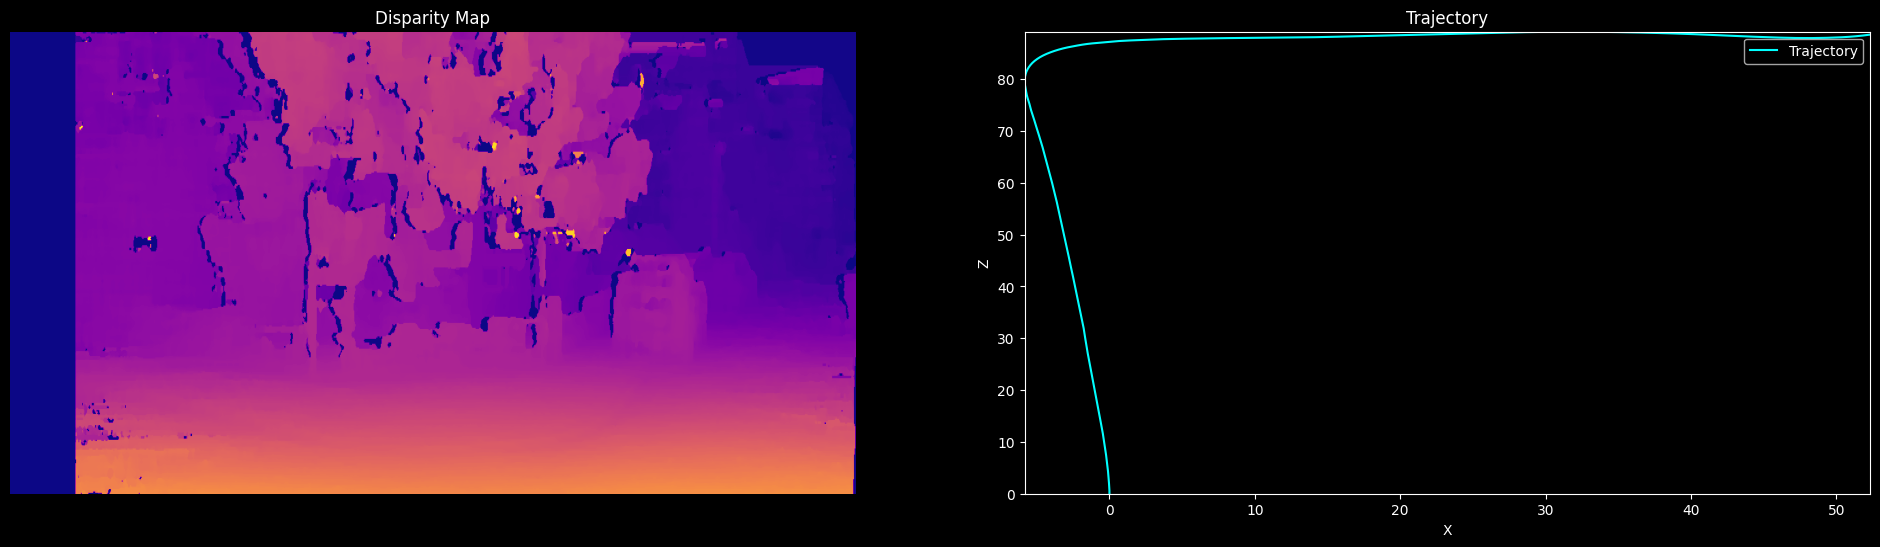

In [73]:
from matplotlib.animation import FuncAnimation
import matplotlib.pyplot as plt

traj_xs = trajectory[:, 0, 3]
traj_ys = trajectory[:, 1, 3]
traj_zs = trajectory[:, 2, 3]

fig, axes = plt.subplots(1, 2, figsize=(24, 6))
image_ax, traj_ax = axes

first_disparity = compute_disparity(images_left[0], images_right[0])
image_plot = image_ax.imshow(first_disparity, cmap='plasma', aspect='auto')
image_ax.axis("off")
image_ax.set_title("Disparity Map")

traj_plot, = traj_ax.plot([], [], "cyan", label="Trajectory")
traj_ax.set_xlabel("X")
traj_ax.set_ylabel("Z")
traj_ax.set_title("Trajectory")
traj_ax.legend()

traj_ax.set_xlim(min(traj_xs), max(traj_xs))
traj_ax.set_ylim(min(traj_zs), max(traj_zs))

def update(frame):
    disparity = compute_disparity(images_left[frame], images_right[frame])
    
    image_plot.set_data(disparity)
    
    image_plot.set_clim(vmin=disparity.min(), vmax=disparity.max())
    
    traj_plot.set_data(traj_xs[:frame + 1], traj_zs[:frame + 1])
    
    return image_plot, traj_plot

ani = FuncAnimation(fig, update, frames=num_images, interval=50, blit=True)

ani.save("trajectory_animation.gif", writer="ffmpeg", fps=2) 
plt.show()